In [1]:
import pandas as pd
import numpy as np
import os
import math
from scipy.io import wavfile
import matplotlib.pyplot as plt
import python_speech_features as psf
# from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import h5py

Using TensorFlow backend.


In [2]:
path = os.getcwd()
temp = path.split('/')
temp.pop(-1)
temp.pop(-1)
path = '/'.join(temp)
filename = '/data_v_7_stc/meta/meta.txt'

### Read meta file

In [3]:
meta = pd.read_csv(path + filename, sep="\t", header=None)
meta.columns = ["filename", "where", "something", "length", "label"]
print(meta.shape)
meta.head(2)

(11307, 5)


,filename,where,something,length,label
0,background_0001.wav,office,0,9.45850,background
1,background_0001_time_stretch_0.wav,office,0,9.98907,background


In [4]:
print(meta["label"].unique(), meta["label"].nunique())
# meta["label"].isnull().sum()
# meta["label"][meta["label"] == 'ring'].count()
# door = 3416
# ring = 713
# speech = 276
meta.shape[0]

['background' 'bags' 'door' 'keyboard' 'knocking_door' 'ring' 'speech'
 'tool'] 8


11307

### Open file

In [5]:
fs, data = wavfile.read(path + '/data_v_7_stc/audio/' + meta["filename"].loc[13])

print(len(data) / meta.length.loc[11])
# meta["filename"].loc[2]
print(fs)

14526.846124567788
22050


<function matplotlib.pyplot.show(*args, **kw)>

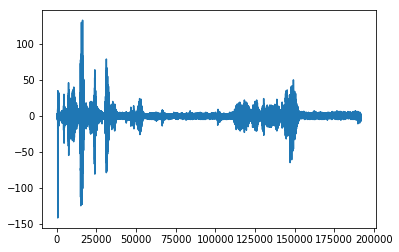

In [6]:
plt.plot(data)
plt.show

In [7]:
def pick_n_each(df, n, shuffle):
    df = df.sample(frac=1).reset_index(drop=True)
    res = pd.DataFrame(columns=df.columns)
    for label in df["label"].unique():
        res = res.append(df[df.label == label].iloc[0:n])
    if shuffle:
        return res.sample(frac=1).reset_index(drop=True)
    return res

In [8]:
N = 5
small = pick_n_each(meta, N, True)
# test = pick_n_each(meta, N, True)

### Create feature vectors

In [9]:
# two types of features - mfcc or logfbank
mfcc = psf.mfcc(data, samplerate=fs, nfft=1024, nfilt=40, numcep=20)
logfbank = psf.logfbank(data, samplerate=fs, nfft=1024, nfilt=40)

# normalize
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
logfbank -= (np.mean(logfbank, axis=0) + 1e-8)

print('MFCC shape:', mfcc.shape)
print('Logfbank shape:', logfbank.shape)

MFCC shape: (868, 20)
Logfbank shape: (868, 40)


<function matplotlib.pyplot.show(*args, **kw)>

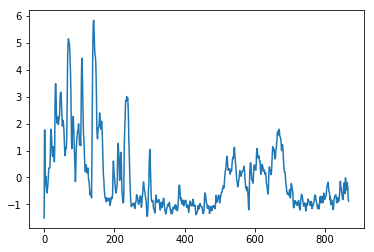

In [10]:
plt.plot(mfcc[:, 0])
plt.show

In [11]:
# add a column with a feature vectors
def make_fv(record):
    # load file
    fs, data = wavfile.read(path + '/data_v_7_stc/audio/' + record)
    # approximately numcep is fs/2000 ~ (8 for 16 kHz and 11 for 22 kHz)
    mfcc = psf.mfcc(data, samplerate=fs, nfft=1024, nfilt=26, numcep=13)
#     fbank = psf.logfbank(data, samplerate=fs, nfft=1024, nfilt=13)
#     features = [mfcc, fbank]
#     features = [mfcc]
    
    # shift and scale
#     for feature in features:
#         feature -= (np.mean(feature, axis=0) + 1e-8)
#         feature /= (np.std(feature, axis=0) + 1e-8)
        
#     vector = np.concatenate((mfcc, fbank), axis=1)
#     vector = mfcc
    
    # can also add deltas at the end of each feature vector
    return mfcc
    
# meta['features'] = meta.filename.apply(lambda x: make_fv(x))
small['features'] = small.filename.apply(lambda x: make_fv(x))
# test['features'] = test.filename.apply(lambda x: make_fv(x))

In [12]:
print(small[small.length > 40].features.iloc[0].shape)
small.head(2)

(5999, 13)


,filename,where,something,length,label,features
0,background_0006_time_stretch_10.wav,office,0,8.06068,background,"[[6.038916083432447, -15.570363206465325, -4.9..."
1,speech_0026_slice_3.wav,office,0,60.00000,speech,"[[10.378684595994446, -20.369290797439973, -2...."


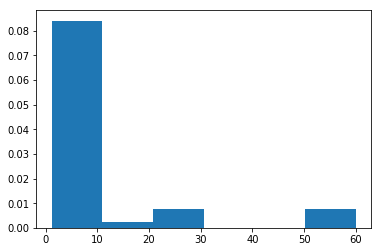

In [13]:
plt.hist(small.length, bins=6, density=True)
plt.show()

### Cut large audiofiles

In [14]:
maxlen = 6  # in seconds

def cut_large(record):
    global maxlen
    if record.length < maxlen:
        res = pd.DataFrame([(record.filename, record.features, record.label)], columns=['filename', 'features', 'label'])
        return res
    
    n_rows = math.ceil(record.length / maxlen)
    df = pd.DataFrame(columns=['filename', 'features', 'label'])
    
    list_of_arrays = np.array_split(record.features, n_rows, axis=0)
    for array in list_of_arrays:
        df = df.append({'filename': record.filename, 'features': array, 'label': record.label}, ignore_index=True)
    
    return df

# list_of_frames = small.apply(lambda x: cut_large(x), axis=1)
# cutted = pd.concat(list(list_of_frames))
# cutted = cutted.reset_index(drop=True)

list_of_frames = small.apply(lambda x: cut_large(x), axis=1)
cutted = pd.concat(list(list_of_frames))
cutted = cutted.reset_index(drop=True)
# cutted.to_json('train_set.json')

### Prepare training data

In [15]:
X_train, Y_train = cutted.features, cutted.label
# X_train, Y_train = small.features, small.label
# X_test, Y_test = test.features, test.label

# pad sequence
# X_train = pad_sequences(X_train)
# X_test = pad_sequences(X_test)

# add zeros at the end
def equalize(array, maxlen, n_features):
    length = array.shape[0]
    if length < maxlen:
        additional = np.array([[0 for i in range(n_features)] for j in range(maxlen - length)])
        res = np.concatenate([array, additional])
        return res
    return array

# pad sequence
def pad_row(series):
    length = max(series.apply(lambda x: len(x)))
    n_features = series[0].shape[1]
    result = series.apply(lambda x: equalize(x, length, n_features))
    return result

tmp = pad_row(X_train)
X_train = np.stack(tmp.values)

# tmp = pad_row(X_test)
# X_test = np.stack(tmp.values)

print('Vectors are padded')

Y_train = pd.get_dummies(Y_train)  # make a dummy target
# Y_test = pd.get_dummies(Y_test)

print(len(X_train), 'train sequences')


# X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=14)

Vectors are padded
83 train sequences


### Save training set

In [16]:
# h5f = h5py.File('train.h5', 'w')
# h5f.create_dataset('train', data=X_train)
# h5f.close()

# h5f = h5py.File('target.h5', 'w')
# h5f.create_dataset('target', data=Y_train)
# h5f.close()

### Build an LSTM-classifier

In [36]:
np.random.seed(14)  # fix the random numbers generator state

batch_size = 10
hidden_units = 30
nb_epochs = 10
nb_classes = 8
dropout = 0.2
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=0, verbose=1)
print('Build model...')

model = Sequential()

# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(units=hidden_units, kernel_initializer='uniform', recurrent_initializer='uniform', dropout=dropout, 
               use_bias=True, unit_forget_bias=True, activation='tanh', recurrent_activation='sigmoid', 
               input_shape=X_train.shape[1:]))
#                forget_bias_init='one', activation='relu', inner_activation='sigmoid', input_shape=X_train.shape[1:]))
# model.add(Dropout(dropout))
# model.add(LSTM(hidden_units, activation='tanh'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# metrics='categorical_accuracy', 'accuracy'
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer=sgd)

# add early stopping
# add bias

print("Train...")
# model.fit(X_train, Y_train, batch_size=batch_size, validation_split=0.2, epochs=2, verbose=1)
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epochs, verbose=1, callbacks=[early_stopping])

# evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Build model...
Train...
Epoch 1/10
 20/217 [=>............................] - ETA: 23s - loss: 2.0524 - categorical_accuracy: 0.3500

KeyboardInterrupt: 

In [36]:
pred = model.predict(X_test, verbose=1)
pd.DataFrame(pred)

73/73 [==============================] - 1s 13ms/step


,0,1,2,3,4,5,6,7
0,0.000051,0.000003,0.000003,0.000025,0.000039,0.000726,0.999022,0.000132
1,0.018326,0.298849,0.062539,0.597396,0.012128,0.002755,0.002843,0.005162
2,0.007723,0.000867,0.003078,0.002057,0.002946,0.965092,0.009277,0.008960
3,0.000064,0.000002,0.000003,0.000019,0.000053,0.000393,0.999434,0.000032
4,0.018352,0.348077,0.078071,0.522639,0.026371,0.002366,0.002140,0.001985
5,0.000046,0.000003,0.000011,0.000017,0.000029,0.000082,0.999737,0.000075
6,0.043757,0.509411,0.092423,0.306794,0.036330,0.002899,0.004081,0.004305
7,0.025737,0.265137,0.135089,0.542945,0.024644,0.002768,0.001811,0.001867
8,0.000694,0.000255,0.000172,0.000541,0.000540,0.000133,0.997001,0.000663
9,0.000007,0.000001,0.000001,0.000004,0.000006,0.000009,0.999951,0.000021


In [37]:
Y_test.reset_index(drop=True)

,background,bags,door,keyboard,knocking_door,ring,speech,tool
0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0
6,1,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0
8,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,1,0


### Visualize the training

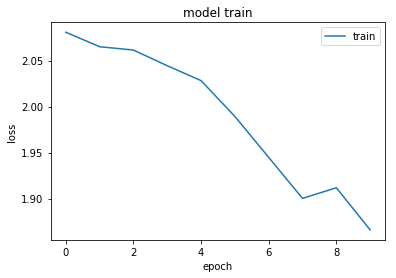

In [86]:
# history = model.fit(X, Y, epochs=100, validation_data=(valX, valY))
plt.plot(history.history['loss'])
plt.title('model train')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

### Bidirectional LSTM

In [35]:
from keras.layers import Bidirectional
np.random.seed(14)  # fix the random numbers generator state

batch_size = 10
hidden_units = 80
nb_epochs = 10
nb_classes = 8
dropout = 0.2
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=0, verbose=1)
print('Build model...')



# model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1), merge_mode=mode))
# model.add(TimeDistributed(Dense(1, activation='sigmoid')))
# model.compile(loss='binary_crossentropy', optimizer='adam')

model = Sequential()

# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(units=hidden_units, kernel_initializer='uniform', recurrent_initializer='uniform', dropout=dropout, 
               use_bias=True, unit_forget_bias=True, activation='tanh', recurrent_activation='sigmoid', 
               input_shape=X_train.shape[1:]), input_shape=X_train.shape[1:], merge_mode='concat'))
#                forget_bias_init='one', activation='relu', inner_activation='sigmoid', input_shape=X_train.shape[1:]))
# model.add(Dropout(dropout))
# model.add(LSTM(hidden_units, activation='tanh'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# metrics='categorical_accuracy', 'accuracy'
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

# add early stopping
# add bias

print("Train...")
# model.fit(X_train, Y_train, batch_size=batch_size, validation_split=0.2, epochs=2, verbose=1)
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epochs, verbose=1, callbacks=[early_stopping])

# evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


Build model...
Train...
Epoch 1/10
288/288 [==============================] - 19s 67ms/step - loss: 1.4070 - categorical_accuracy: 0.4688
Epoch 2/10
288/288 [==============================] - 18s 64ms/step - loss: 0.9938 - categorical_accuracy: 0.6424
Epoch 3/10
288/288 [==============================] - 18s 64ms/step - loss: 0.8752 - categorical_accuracy: 0.6910
Epoch 4/10
288/288 [==============================] - 18s 64ms/step - loss: 0.7948 - categorical_accuracy: 0.7049
Epoch 5/10
288/288 [==============================] - 18s 64ms/step - loss: 0.7121 - categorical_accuracy: 0.7535
Epoch 6/10
288/288 [==============================] - 18s 64ms/step - loss: 0.6706 - categorical_accuracy: 0.7500
Epoch 7/10
288/288 [==============================] - 18s 64ms/step - loss: 0.6094 - categorical_accuracy: 0.7882
Epoch 8/10
288/288 [==============================] - 18s 64ms/step - loss: 0.6488 - categorical_accuracy: 0.7500
Epoch 00008: early stopping
73/73 [=============================